# AUEB M.Sc. in Data Science

- Course: **Deep Learning**

- Semester: Spring 2020

- Instructor: Prof. P Malakasiotis

- Author: S. Politis (p3351814)

- Homework: 1

## Import required libraries and custom packages

In [1]:
import importlib
import logging
import numpy as np
import platform
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import talos
import tensorflow as tf
import tensorflow_addons as tfa
import time

Using TensorFlow backend.


In [2]:
sys.path.append("../code/")

from AUEB.DL.H001 import Examples
from AUEB.DL.H001 import Logger
from AUEB.DL.H001.Data import FashionMNISTReader
from AUEB.DL.H001.Evaluation import Evaluate
from AUEB.DL.H001.Visualization import Visualization
from AUEB.DL.H001.Model import CNN

## Setup globals

In [3]:
# Required for GraphViz.
if platform.system() == "Windows":
    os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/"
elif platform.system() == "Linux":
    os.environ["PATH"] += os.pathsep + "/usr/lib/x86_64-linux-gnu/graphviz"

log = Logger.create_logger(
    name = "msc-ds-dl-h-001", 
    level = logging.DEBUG
)

class_names = [
    "T-shirt/top", 
    "Trouser", 
    "Pullover", 
    "Dress", 
    "Coat",
    "Sandal", 
    "Shirt", 
    "Sneaker", 
    "Bag", 
    "Ankle boot"
]

Set the *Numpy* and *Tensorflow* seed so that stochasticity in repeated experimentation is removed and results are reproducible, especially when performing hyperparameter tuning.

In [4]:
random_seed = 19730618
np.random.seed(random_seed)
tf.random.set_seed = random_seed

Inspect our environment characteristics:

In [5]:
# Environment characteristics.
log.info(
    f"\n\nTensorflow ver.\t\t{tf.version.VERSION}\nBuilt with CUDA:\t{tf.test.is_built_with_cuda()}\nGPU:\t\t\t{tf.config.list_physical_devices('GPU')}"
)

2020-06-09 07:31:02,279	[INFO]	msc-ds-dl-h-001	<ipython-input-5-07dd36878476>.<module>: 

Tensorflow ver.		2.1.0
Built with CUDA:	True
GPU:			[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Ingest data

In [6]:
X_train, y_train = FashionMNISTReader.load_mnist(path = "../data/fashion",  kind = "train")
X_test, y_test = FashionMNISTReader.load_mnist(path = "../data/fashion",  kind = "t10k")

2020-06-09 07:31:02,537	[INFO]	msc-ds-dl-h-001	FashionMNISTReader.load_mnist: Done loading Fashion-MNIST train data
2020-06-09 07:31:02,588	[INFO]	msc-ds-dl-h-001	FashionMNISTReader.load_mnist: Done loading Fashion-MNIST t10k data


In [7]:
# Data shapes.
log.info(
    f"\n\nDataset shapes\n\nX_train\t{X_train.shape}\ny_train\t{y_train.shape}\nX_test\t{X_test.shape}\ny_test\t{y_test.shape}"
)

2020-06-09 07:31:02,591	[INFO]	msc-ds-dl-h-001	<ipython-input-7-349ebb213b47>.<module>: 

Dataset shapes

X_train	(60000, 784)
y_train	(60000,)
X_test	(10000, 784)
y_test	(10000,)


## Explore data

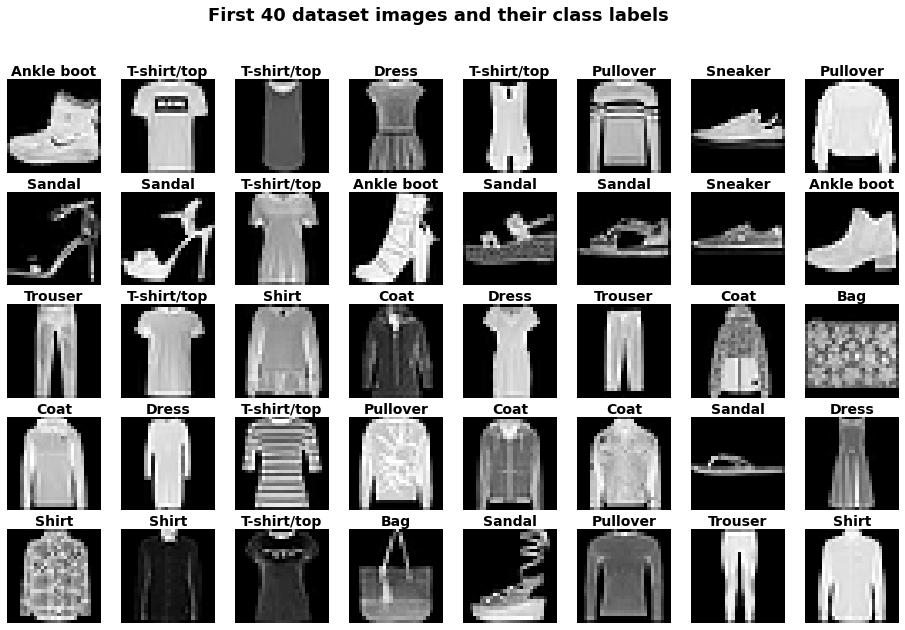

In [8]:
n_images = 40

Visualization.plot_images(
    data = X_train[0:n_images, :], 
    labels = [class_names[i] for i in y_train[0:n_images]], 
    nrows = 5, 
    title = f"First {n_images} dataset images and their class labels", 
    figsize = (16, 10)
);

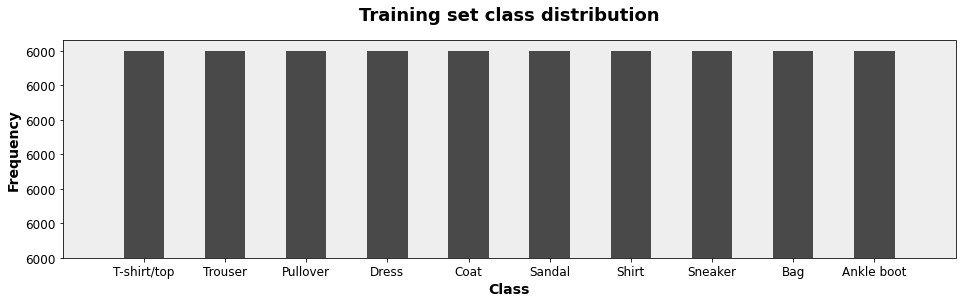

In [9]:
Visualization.plot_hist(
    data = y_train.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Training set class distribution"
);

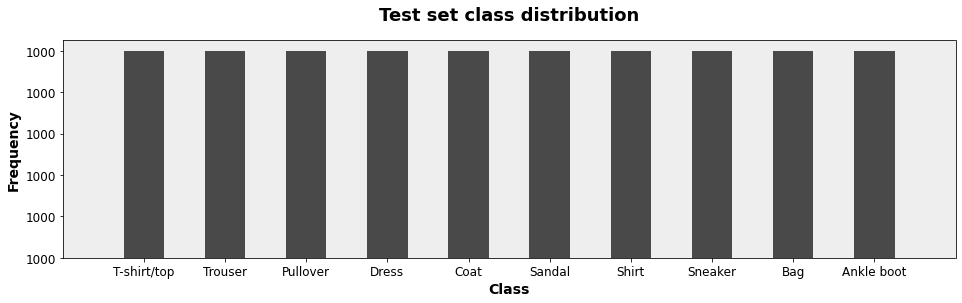

In [10]:
Visualization.plot_hist(
    data = y_test.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Test set class distribution"
);

We observe that the distribution of classes in both the training and the test set are uniformly distributed, hence the dataset does not present a class imbalance problem.  

## Splitting data into train / dev / test sets

Since our dataset has already been split to train / test sets (*(X_train, y_train)*, *(X_test, y_test)* respectively), we shall proceed further by retaining a percentage ($0.1$) of the training data for creating a development set. The development set will be used for tuning hyperparameters of the model architectures, so as to acquire a robust model for inference.

We shall also be extra careful to retain the uniform nature of the target class distribution so as not to introduce bias. To do this, we shall split the sets in a stratified fashion.

In [11]:
import sklearn.model_selection

X_train, X_dev, y_train, y_dev = sklearn.model_selection.train_test_split(
    X_train, 
    y_train, 
    test_size = 0.2, 
    stratify = y_train, 
    random_state = random_seed, 
    shuffle = True
)

Inspecting the set dimensions:

In [13]:
# Data shapes.
log.info(
    f"\n\nDataset shapes\n\nX_train\t{X_train.shape}\ny_train\t{y_train.shape}\nX_dev\t{X_dev.shape}\ny_dev\t{y_dev.shape}\nX_test\t{X_test.shape}\ny_test\t{y_test.shape}"
)

2020-06-09 07:31:31,524	[INFO]	msc-ds-dl-h-001	<ipython-input-13-7e58ccfaf9ac>.<module>: 

Dataset shapes

X_train	(48000, 784)
y_train	(48000,)
X_dev	(12000, 784)
y_dev	(12000,)
X_test	(10000, 784)
y_test	(10000,)


Inspecting the set target class distributions:

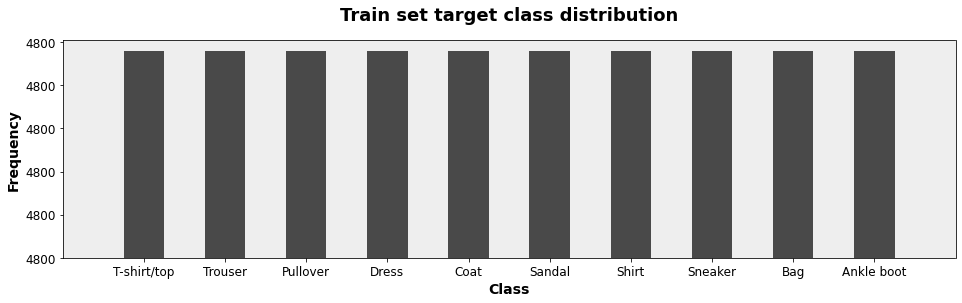

In [14]:
Visualization.plot_hist(
    data = y_train.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Train set target class distribution"
);

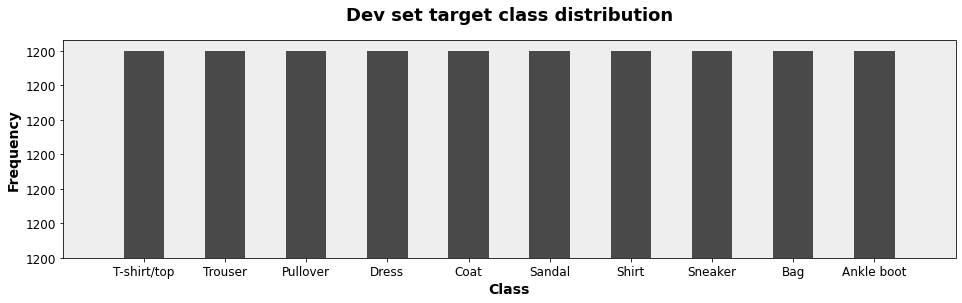

In [15]:
Visualization.plot_hist(
    data = y_dev.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Dev set target class distribution"
);

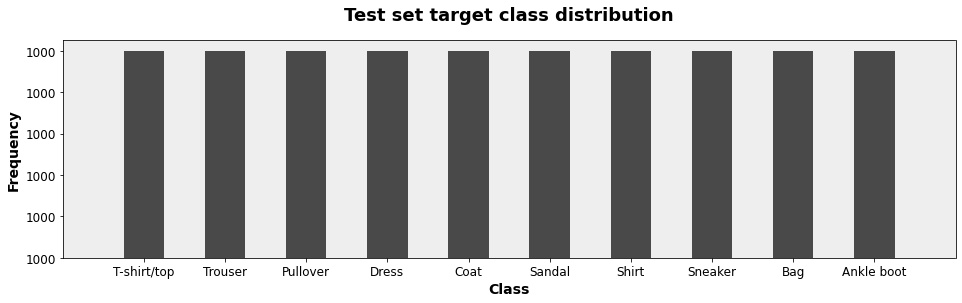

In [16]:
Visualization.plot_hist(
    data = y_test.astype(np.int8), 
    x_label = "Class", 
    y_label = "Frequency", 
    x_tick_labels = class_names, 
    figsize = (16, 4), 
    title = "Test set target class distribution"
);

## Normalize pixel values

The purpose of normalization is to fit the feature space to $[0, 1]$, because unscaled input variables can result in a slow or unstable learning process.

In [17]:
X_train = X_train / 255
X_dev = X_dev / 255
X_test = X_test / 255

## Reshape data

In [18]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_dev = X_dev.reshape(X_dev.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Classification

### Tensorflow callbacks

#### Early stopping

In [19]:
def early_stopping_callback(
    monitor: str = "val_loss", 
    min_delta = 0, 
    patience = 0
):
    return tf.keras.callbacks.EarlyStopping(
        monitor = monitor, 
        min_delta = min_delta, 
        patience = patience, 
        mode = "auto", 
        verbose = 0
    )

#### TQDM progress bar

In [20]:
def tqdm_callback():
    return tfa.callbacks.TQDMProgressBar()

#### Tensorboard

In [21]:
def tensor_board_callback(model_name:str = None):     
    return tf.keras.callbacks.TensorBoard(
        log_dir = f"logs{os.path.sep}{model_name}", 
        histogram_freq = 0, 
        write_graph = True, 
        write_images = False,
        update_freq = "epoch", 
        profile_batch = 2, 
        embeddings_freq = 0,
        embeddings_metadata = None
    )

### Experiments

The strategy is starting off from a baseline model and possibly identify better results by refining it architecture, going forward.

We shall explore a CNN architecture.

#### CNN

In [22]:
cnn = CNN.CNN(random_seed = random_seed)

##### A small CNN (1 convolutional layer with 32 filters)

In [23]:
model_name = f"fashion-mnist-cnn-small-relu-{int(time.time())}"

cnn_small = cnn.create(
    model_name = model_name, 
    input_shape = (28, 28, 1, ), 
    conv_layers_spec = [
        {
            "filters": 32, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same",
            "dilation_rate": (1, 1),
            "activation": "relu", 
            "max_pool_2d": {
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same",
            }
        }
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [24]:
cnn_small.summary()

Model: "fashion-mnist-cnn-small-relu-1591677112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 6272)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                62730     
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________


##### A medium CNN (2 convolutional layers with 32 / 64 filters)

In [25]:
model_name = f"fashion-mnist-cnn-medium-relu-{int(time.time())}"

cnn_medium = cnn.create(
    model_name = model_name, 
    input_shape = (28, 28, 1, ), 
    conv_layers_spec = [
        {
            "filters": 32, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same",
            "dilation_rate": (1, 1),
            "activation": "relu", 
            "max_pool_2d": {
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same",
            }
        },
        {
            "filters": 64, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same", 
            "dilation_rate": (1, 1), 
            "activation": "relu", 
            "max_pool_2d": { 
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same", 
            }
        }
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [26]:
cnn_medium.summary()

Model: "fashion-mnist-cnn-medium-relu-1591677114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 3136)              0         
_________________________________________________________________
output_layer (Dense)      

##### A large CNN (3 convolutional layers with 32 / 64 / 128 filters)

In [27]:
model_name = f"fashion-mnist-cnn-large-relu-{int(time.time())}"

cnn_large = cnn.create(
    model_name = model_name, 
    input_shape = (28, 28, 1, ), 
    conv_layers_spec = [
        {
            "filters": 32, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same",
            "dilation_rate": (1, 1),
            "activation": "relu", 
            "max_pool_2d": {
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same",
            }
        },
        {
            "filters": 64, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same", 
            "dilation_rate": (1, 1), 
            "activation": "relu", 
            "max_pool_2d": { 
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same", 
            }
        },
        {
            "filters": 128, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same",
            "dilation_rate": (1, 1), 
            "activation": "relu", 
            "max_pool_2d": {
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same",
            }
        }
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [28]:
cnn_large.summary()

Model: "fashion-mnist-cnn-large-relu-1591677114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
conv_2d_layer_3 (Conv2D)     (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pool_2d_layer_3 (MaxPoo

In [29]:
cnns = {
    "cnn_small": cnn_small,
    "cnn_medium": cnn_medium,
    "cnn_large": cnn_large
}

##### Training the CNNs with different optimizers

###### SGD

In [30]:
histories = {}

optimizer = tf.keras.optimizers.SGD(
    lr = 0.01, 
    momentum = 0.9, 
    nesterov = True
)

for cnn in cnns.items():
    cnn_label = cnn[0]
    cnn_model = cnn[1]
    
    log.info(f"Training model {cnn_label}")
    
    cnn_model.compile(
        optimizer = optimizer, 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
        metrics = [ 
            "accuracy"
        ]
    )
    
    histories[cnn_label] = cnn_model.fit(
        X_train, 
        y_train, 
        epochs = 100, 
        batch_size = 32, 
        validation_split = 0.1, 
        # validation_data = (X_dev, y_dev), 
        callbacks = [
    #         early_stopping_callback(
    #             monitor = "val_loss", 
    #             patience = 5
    #         ), 
    #        tensor_board_callback(model_name = model_name), 
            tqdm_callback()
        ], 
        verbose = 0
    )

2020-06-09 07:31:59,658	[INFO]	msc-ds-dl-h-001	<ipython-input-30-7b5076727e78>.<module>: Training model cnn_small


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


2020-06-09 07:36:30,677	[INFO]	msc-ds-dl-h-001	<ipython-input-30-7b5076727e78>.<module>: Training model cnn_medium


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


2020-06-09 07:42:12,553	[INFO]	msc-ds-dl-h-001	<ipython-input-30-7b5076727e78>.<module>: Training model cnn_large


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100



Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


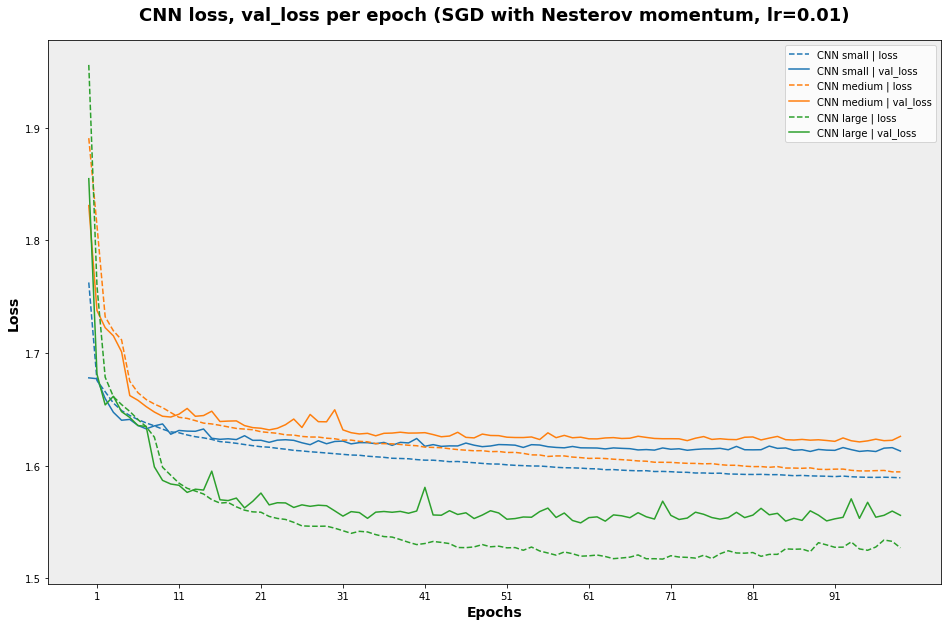

In [31]:
Visualization.plot_training_history(
    histories = {
        "CNN small |": histories["cnn_small"], 
        "CNN medium |": histories["cnn_medium"], 
        "CNN large |": histories["cnn_large"], 
    }, 
    metrics = ["loss", "val_loss"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "CNN loss, val_loss per epoch (SGD with Nesterov momentum, lr=0.01)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

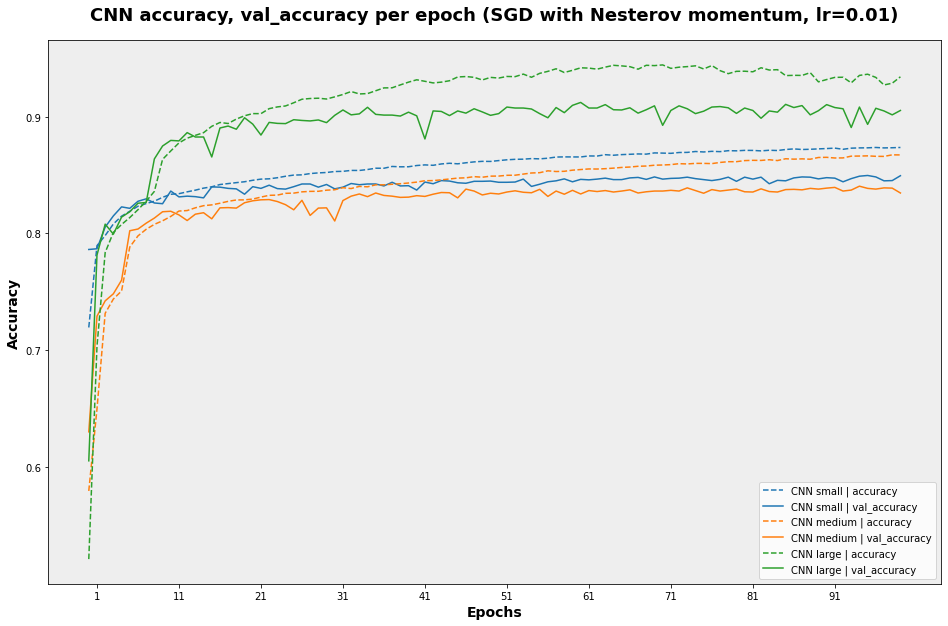

In [32]:
importlib.reload(Visualization)
Visualization.plot_training_history(
    histories = {
        "CNN small |": histories["cnn_small"], 
        "CNN medium |": histories["cnn_medium"], 
        "CNN large |": histories["cnn_large"], 
    }, 
    metrics = ["accuracy", "val_accuracy"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "CNN accuracy, val_accuracy per epoch (SGD with Nesterov momentum, lr=0.01)", 
    x_label = "Epochs", 
    y_label = "Accuracy"
);

In [33]:
Evaluate.Evaluate().evaluate(histories, X_test, y_test).to_df()

10000/10000 [==============================] - 1s 74us/sample - loss: 1.5668 - accuracy: 0.8941


,test_loss,test_accuracy
cnn_small,1.615897,0.8448
cnn_medium,1.629447,0.8309
cnn_large,1.566829,0.8941


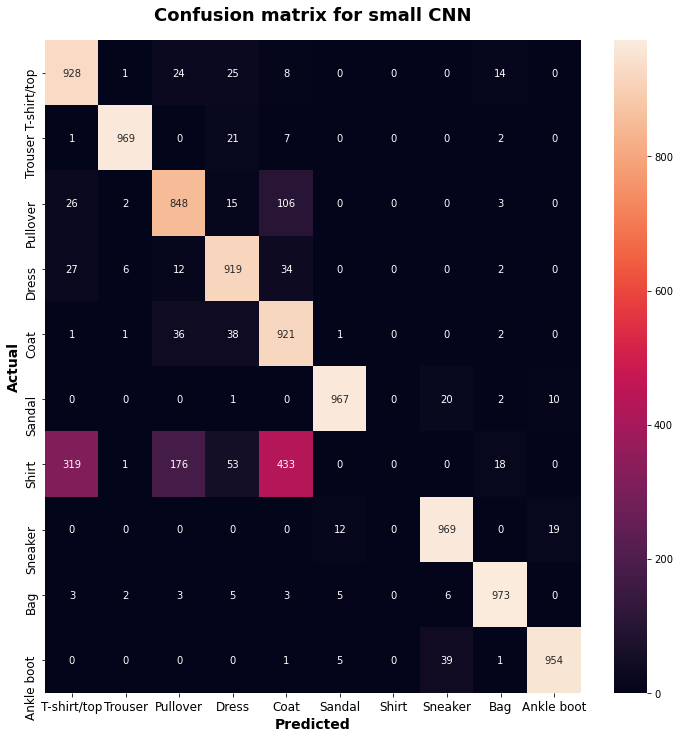

In [34]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_small.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for small CNN", 
    figsize = (12, 12)
)

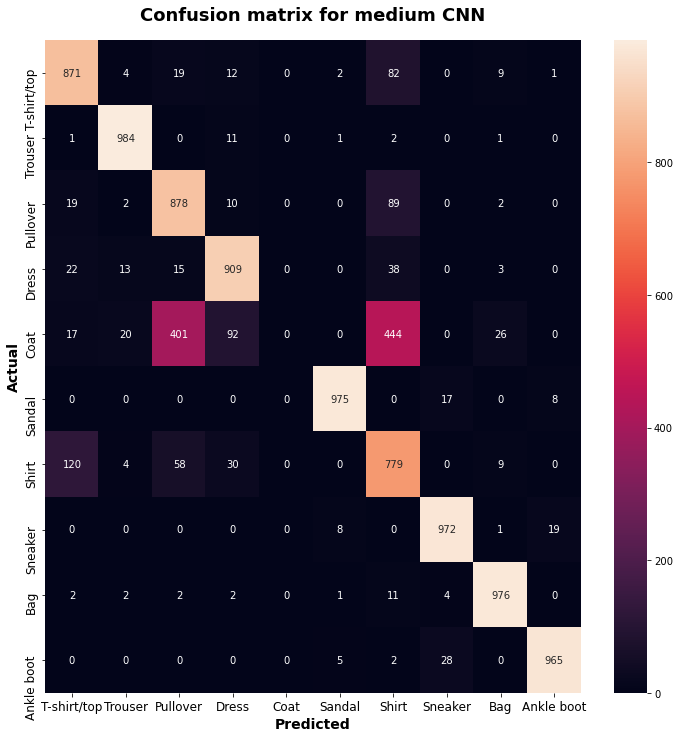

In [35]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_medium.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for medium CNN", 
    figsize = (12, 12)
)

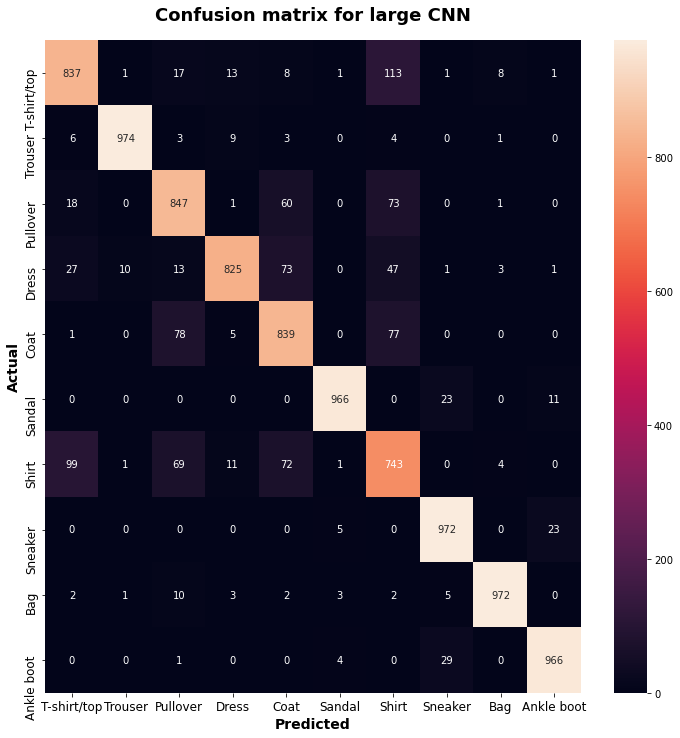

In [36]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_large.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for large CNN", 
    figsize = (12, 12)
)

###### Adam

In [ ]:
histories = {}

optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps = (X_train.shape[0] / 32) * 1000, 
      decay_rate = 1,
      staircase = False
    )
)

for cnn in cnns.items():
    cnn_label = cnn[0]
    cnn_model = cnn[1]
    
    log.info(f"Training model {cnn_label}")
    
    cnn_model.compile(
        optimizer = optimizer, 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
        metrics = [
            "accuracy"
        ]
    )
    
    histories[cnn_label] = cnn_model.fit(
        X_train, 
        y_train, 
        epochs = 100, 
        batch_size = 32, 
        validation_split = 0.1, 
        # validation_data = (X_dev, y_dev), 
        callbacks = [
    #         early_stopping_callback(
    #             monitor = "val_loss", 
    #             patience = 5
    #         ), 
    #        tensor_board_callback(model_name = model_name), 
            tqdm_callback()
        ], 
        verbose = 0
    )

In [ ]:
Visualization.plot_training_history(
    histories = {
        "CNN small |": histories["cnn_small"], 
        "CNN medium |": histories["cnn_medium"], 
        "CNN large |": histories["cnn_large"]
    }, 
    metrics = ["loss", "val_loss"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "CNN loss, val_loss per epoch (Adam, inverse time decay)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

In [ ]:
Visualization.plot_training_history(
    histories = {
        "CNN small |": histories["cnn_small"], 
        "CNN medium |": histories["cnn_medium"], 
        "CNN large |": histories["cnn_large"], 
    }, 
    metrics = ["accuracy", "val_accuracy"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "CNN accuracy, val_accuracy per epoch (Adam, inverse time decay)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

In [ ]:
Evaluate.Evaluate().evaluate(histories, X_test, y_test).to_df()

In [ ]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_small.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for small CNN", 
    figsize = (12, 12)
)

In [ ]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_medium.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for medium CNN", 
    figsize = (12, 12)
)

In [ ]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_large.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for large CNN", 
    figsize = (12, 12)
)

#### Introducing regularization with *dropout*

In [38]:
cnn = CNN.CNN(random_seed = random_seed)

##### A small CNN (1 convolutional layer with 32 filters)

In [39]:
model_name = f"fashion-mnist-cnn-small-relu-{int(time.time())}"

cnn_small = cnn.create(
    model_name = model_name, 
    input_shape = (28, 28, 1, ), 
    conv_layers_spec = [
        {
            "filters": 32, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same",
            "dilation_rate": (1, 1),
            "activation": "relu", 
            "max_pool_2d": {
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same",
            }, 
            "dropout": {
                "rate": 0.2
            }
        }
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [40]:
cnn_small.summary()

Model: "fashion-mnist-cnn-small-relu-1591679266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 6272)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                62730     
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_______________________

##### A medium CNN (2 convolutional layers with 32 / 64 filters)

In [41]:
model_name = f"fashion-mnist-cnn-medium-relu-{int(time.time())}"

cnn_medium = cnn.create(
    model_name = model_name, 
    input_shape = (28, 28, 1, ), 
    conv_layers_spec = [
        {
            "filters": 32, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same",
            "dilation_rate": (1, 1),
            "activation": "relu", 
            "max_pool_2d": {
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same",
            }, 
            "dropout": {
                "rate": 0.2
            }
        },
        {
            "filters": 64, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same", 
            "dilation_rate": (1, 1), 
            "activation": "relu", 
            "max_pool_2d": { 
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same", 
            }, 
            "dropout": {
                "rate": 0.2
            }
        }
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [42]:
cnn_medium.summary()

Model: "fashion-mnist-cnn-medium-relu-1591679273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout) 

##### A large CNN (3 convolutional layers with 32 / 64 / 128 filters)

In [43]:
model_name = f"fashion-mnist-cnn-large-relu-{int(time.time())}"

cnn_large = cnn.create(
    model_name = model_name, 
    input_shape = (28, 28, 1, ), 
    conv_layers_spec = [
        {
            "filters": 32, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same",
            "dilation_rate": (1, 1),
            "activation": "relu", 
            "max_pool_2d": {
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same",
            }, 
            "dropout": {
                "rate": 0.2
            }
        },
        {
            "filters": 64, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same", 
            "dilation_rate": (1, 1), 
            "activation": "relu", 
            "max_pool_2d": { 
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same", 
            }, 
            "dropout": {
                "rate": 0.2
            }
        },
        {
            "filters": 128, 
            "kernel_size": (3, 3), 
            "strides": (1, 1), 
            "padding": "same",
            "dilation_rate": (1, 1), 
            "activation": "relu", 
            "max_pool_2d": {
                "pool_size": (2, 2), 
                "strides": (2, 2), 
                "padding": "same",
            }
        }
    ], 
    output_layer_spec = {
        "units": 10, 
        "kernel_initializer": tf.keras.initializers.he_uniform(seed = random_seed), 
        "activation": "softmax"
    }
)

In [44]:
cnn_large.summary()

Model: "fashion-mnist-cnn-large-relu-1591679275"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)  

In [45]:
cnns = {
    "cnn_small": cnn_small,
    "cnn_medium": cnn_medium,
    "cnn_large": cnn_large
}

##### Training the CNNs with different optimizers

###### SGD

In [47]:
histories = {}

optimizer = tf.keras.optimizers.SGD(
    lr = 0.01, 
    momentum = 0.9, 
    nesterov = True
)

for cnn in cnns.items():
    cnn_label = cnn[0]
    cnn_model = cnn[1]
    
    log.info(f"Training model {cnn_label}")
    
    cnn_model.compile(
        optimizer = optimizer, 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
        metrics = [ 
            "accuracy"
        ]
    )
    
    histories[cnn_label] = cnn_model.fit(
        X_train, 
        y_train, 
        epochs = 100, 
        batch_size = 32, 
        validation_split = 0.1, 
        # validation_data = (X_dev, y_dev), 
        callbacks = [
            early_stopping_callback(
                monitor = "val_loss", 
                patience = 5
            ), 
    #        tensor_board_callback(model_name = model_name), 
            tqdm_callback()
        ], 
        verbose = 0
    )

2020-06-09 08:08:38,483	[INFO]	msc-ds-dl-h-001	<ipython-input-47-5b4b633e68ed>.<module>: Training model cnn_small


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100


2020-06-09 08:11:12,748	[INFO]	msc-ds-dl-h-001	<ipython-input-47-5b4b633e68ed>.<module>: Training model cnn_medium


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100


2020-06-09 08:14:08,743	[INFO]	msc-ds-dl-h-001	<ipython-input-47-5b4b633e68ed>.<module>: Training model cnn_large


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100


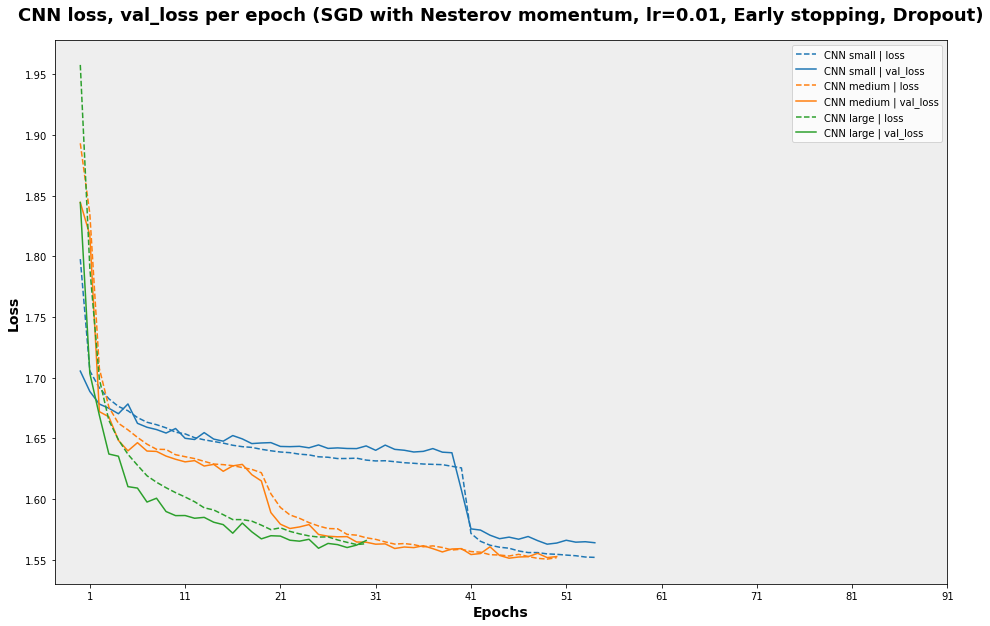

In [48]:
Visualization.plot_training_history(
    histories = {
        "CNN small |": histories["cnn_small"], 
        "CNN medium |": histories["cnn_medium"], 
        "CNN large |": histories["cnn_large"], 
    }, 
    metrics = ["loss", "val_loss"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "CNN loss, val_loss per epoch (SGD with Nesterov momentum, lr=0.01, Early stopping, Dropout)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

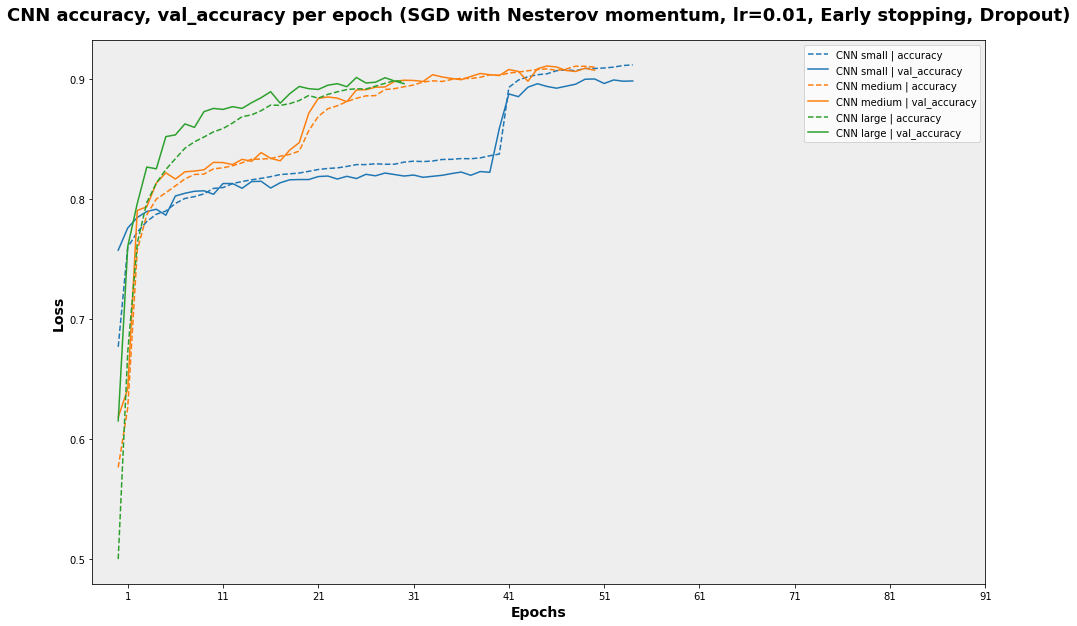

In [49]:
importlib.reload(Visualization)
Visualization.plot_training_history(
    histories = {
        "CNN small |": histories["cnn_small"], 
        "CNN medium |": histories["cnn_medium"], 
        "CNN large |": histories["cnn_large"], 
    }, 
    metrics = ["accuracy", "val_accuracy"], 
    epochs = 100, 
    figsize = (16, 10), 
    title = "CNN accuracy, val_accuracy per epoch (SGD with Nesterov momentum, lr=0.01, Early stopping, Dropout)", 
    x_label = "Epochs", 
    y_label = "Loss"
);

In [50]:
Evaluate.Evaluate().evaluate(histories, X_test, y_test).to_df()

10000/10000 [==============================] - 1s 71us/sample - loss: 1.5763 - accuracy: 0.8841


,test_loss,test_accuracy
cnn_small,1.571237,0.8914
cnn_medium,1.558384,0.9038
cnn_large,1.576308,0.8841


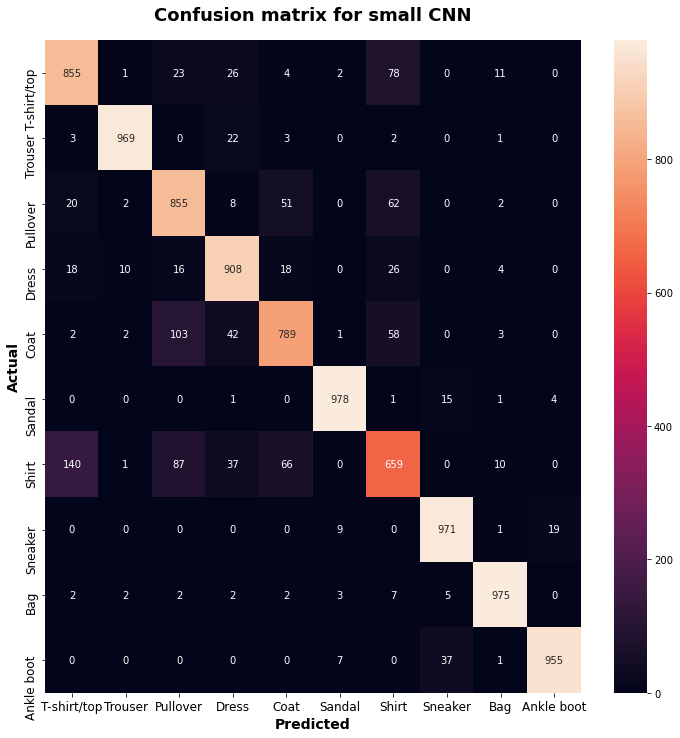

In [51]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_small.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for small CNN", 
    figsize = (12, 12)
)

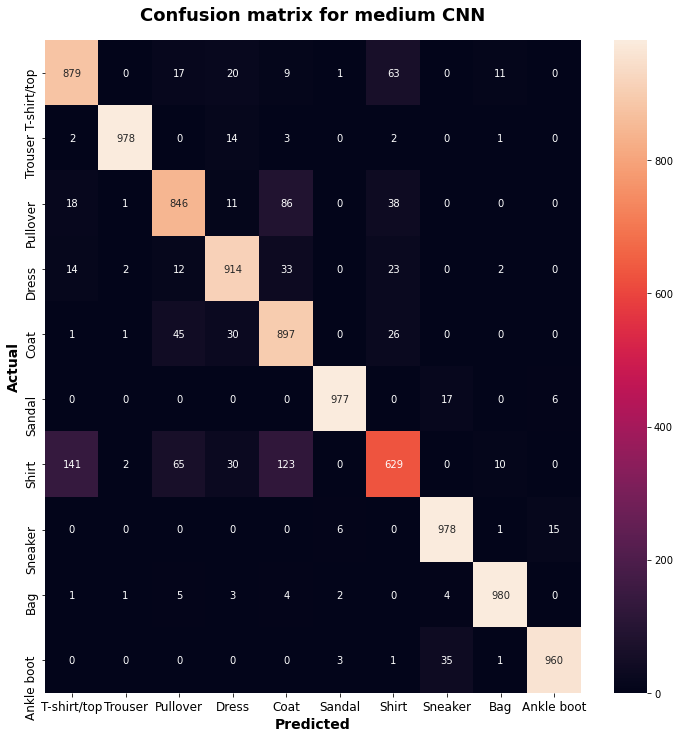

In [52]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_medium.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for medium CNN", 
    figsize = (12, 12)
)

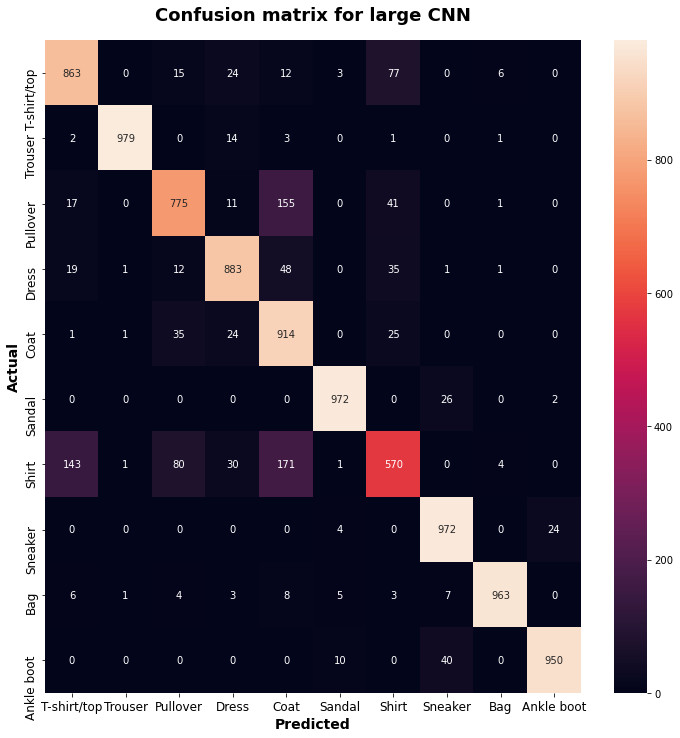

In [53]:
Visualization.plot_confusion_matrix(
    y_true = y_test, 
    y_pred = tf.argmax(input = cnn_large.predict(X_test), axis = 1).numpy(), 
    labels = class_names, 
    normalize = None, 
    title = "Confusion matrix for large CNN", 
    figsize = (12, 12)
)

#### Hyperparameter tuning of medium CNN with Talos

In [54]:
import talos
from talos.model.early_stopper import early_stopper

In [59]:
# Redefining the CNN generator to work with Talos.
def cnn(X_train, y_train, X_val, y_val, hyperparameters):
    # Input layer (None, 28, 28)
    input_layer = tf.keras.layers.Input(
        shape = (28, 28, 1), 
        name = "input_layer"
    )

    l = input_layer

    # 2 convolutional layers, paired with max pooling and dropout.
    # Layer 1.
    l = tf.keras.layers.Conv2D(
        filters = hyperparameters["first_layer_conv_filters"],
        kernel_size = hyperparameters["first_layer_conv_kernel_size"],
        strides = hyperparameters["first_layer_conv_strides"], 
        padding = hyperparameters["first_layer_conv_padding"], 
        dilation_rate = hyperparameters["first_layer_conv_dilation_rate"], 
        activation = hyperparameters["first_layer_activation"], 
        name = "conv_2d_layer_1"
    )(l)

    l = tf.keras.layers.MaxPool2D(
        pool_size = hyperparameters["first_layer_maxpool_pool_size"], 
        strides = hyperparameters["first_layer_maxpool_strides"], 
        padding = hyperparameters["first_layer_maxpool_padding"], 
        name = "max_pool_2d_layer_1"
    )(l)

    # Droput.
    l = tf.keras.layers.Dropout(
        rate = hyperparameters["dropout"], 
        name = "dropout_layer_1"
    )(l)
    
    # Layer 2.
    l = tf.keras.layers.Conv2D(
        filters = hyperparameters["second_layer_conv_filters"],
        kernel_size = hyperparameters["second_layer_conv_kernel_size"],
        strides = hyperparameters["second_layer_conv_strides"], 
        padding = hyperparameters["second_layer_conv_padding"], 
        dilation_rate = hyperparameters["second_layer_conv_dilation_rate"], 
        activation = hyperparameters["second_layer_activation"], 
        name = "conv_2d_layer_2"
    )(l)

    l = tf.keras.layers.MaxPool2D(
        pool_size = hyperparameters["second_layer_maxpool_pool_size"], 
        strides = hyperparameters["second_layer_maxpool_strides"], 
        padding = hyperparameters["second_layer_maxpool_padding"], 
        name = "max_pool_2d_layer_2"
    )(l)

    # Droput.
    l = tf.keras.layers.Dropout(
        rate = hyperparameters["dropout"], 
        name = "dropout_layer_2"
    )(l)
    
    # Flatten.
    l = tf.keras.layers.Flatten(
        name = "flatten_layer"
    )(l)

    # Define the output layer.
    output_layer = tf.keras.layers.Dense(
        units = 10,
        activation = hyperparameters["output_activation"],
        name = "output_layer"
    )(l)

    model = tf.keras.models.Model(
        inputs = input_layer, 
        outputs = output_layer, 
        name = "cnn_optimized"
    )
    
    model.compile(
        optimizer = hyperparameters["optimizer"],
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ["acc"]
    )
    
    display(model.summary())
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs = hyperparameters["epochs"],
        validation_data = (X_val, y_val), 
        batch_size = hyperparameters["batch_size"], 
        callbacks = [
            early_stopping_callback(
                monitor = "val_loss", 
                patience = 5
            )
        ], 
        verbose = 0
    )
    
    return history, model

In [68]:
# Define the hyperparameters search space.
# See:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
hyperparameters = {
    "batch_size": [32], 
    "learning_rate": [0.01, 0.001], 
    "dropout": [0.1, 0.2, 0.3], 
    
    # The number of output filters in the convolution.
    "first_layer_conv_filters": [32, 64, 128], 
    # Height and width of the 2D convolution window.
    "first_layer_conv_kernel_size": [(3, 3), (5, 5)], 
    # Strides of the convolution along the height and width.
    # Values larger than 2 are rare in practice (see https://cs231n.github.io/convolutional-networks/)
    "first_layer_conv_strides": [(1, 1), (2, 2)], 
    "first_layer_conv_padding": ["same"], 
    "first_layer_conv_dilation_rate": [(1, 1)], 
    "first_layer_activation": ["relu"], 
    # Window size over which to take the maximum.
    "first_layer_maxpool_pool_size": [(2, 2)], 
    # Specifies how far the pooling window moves for each pooling step.
    "first_layer_maxpool_strides": [(1, 1)], 
    "first_layer_maxpool_padding": ["same"], 
    
    # The number of output filters in the convolution.
    "second_layer_conv_filters": [32, 64, 128], 
    # Height and width of the 2D convolution window.
    "second_layer_conv_kernel_size": [(3, 3), (5, 5)], 
    # Strides of the convolution along the height and width.
    # Values larger than 2 are rare in practice (see https://cs231n.github.io/convolutional-networks/)
    "second_layer_conv_strides": [(1, 1), (2, 2)], 
    "second_layer_conv_padding": ["same"], 
    "second_layer_conv_dilation_rate": [(1, 1)], 
    "second_layer_activation": ["relu"], 
    # Window size over which to take the maximum.
    "second_layer_maxpool_pool_size": [(2, 2)], 
    # Specifies how far the pooling window moves for each pooling step.
    "second_layer_maxpool_strides": [(1, 1)], 
    "second_layer_maxpool_padding": ["same"], 
    
    "output_activation": [tf.keras.activations.relu], 
    
    "optimizer": [
        tf.keras.optimizers.SGD(
            lr = 0.01, 
            momentum = 0.9, 
            nesterov = True
        ), 
        tf.keras.optimizers.Adam()
    ], 
    "epochs": [100]
}

# Setup the Talos scan object.
talos_history = talos.Scan(
    x = X_train, 
    y = y_train, 
    x_val = X_dev, 
    y_val = y_dev, 
    params = hyperparameters, 
    model = cnn, 
    # Stochastic grid search downsample.
    fraction_limit = 0.1, 
    experiment_name = "cnn-hyperparameter-tuning", 
    print_params = False
)








  0%|                                                                                          | 0/172 [00:00<?, ?it/s]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








  1%|▍                                                                               | 1/172 [00:59<2:49:41, 59.54s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








  1%|▉                                                                               | 2/172 [02:31<3:16:33, 69.37s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








  2%|█▍                                                                              | 3/172 [04:34<4:00:45, 85.48s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








  2%|█▊                                                                             | 4/172 [07:22<5:08:17, 110.11s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








  3%|██▎                                                                            | 5/172 [08:42<4:41:03, 100.98s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








  3%|██▊                                                                            | 6/172 [11:10<5:18:38, 115.17s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








  4%|███▏                                                                           | 7/172 [13:01<5:13:17, 113.93s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








  5%|███▋                                                                            | 8/172 [13:34<4:04:40, 89.51s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








  5%|████▏                                                                          | 9/172 [16:15<5:01:50, 111.11s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








  6%|████▌                                                                         | 10/172 [21:33<7:47:25, 173.12s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








  6%|████▉                                                                         | 11/172 [24:18<7:37:53, 170.64s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








  7%|█████▎                                                                       | 12/172 [31:04<10:43:25, 241.28s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








  8%|█████▊                                                                       | 13/172 [41:04<15:24:33, 348.89s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








  8%|██████▎                                                                      | 14/172 [45:25<14:09:35, 322.63s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








  9%|██████▋                                                                      | 15/172 [47:56<11:49:05, 270.99s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








  9%|███████▏                                                                     | 16/172 [50:38<10:19:55, 238.43s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 10%|███████▋                                                                      | 17/172 [51:30<7:51:08, 182.38s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 10%|████████▏                                                                     | 18/172 [53:08<6:43:42, 157.29s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 11%|████████▌                                                                     | 19/172 [54:49<5:57:20, 140.13s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 12%|█████████                                                                     | 20/172 [56:34<5:29:01, 129.88s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 12%|█████████▌                                                                    | 21/172 [58:59<5:38:09, 134.37s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 13%|█████████▋                                                                  | 22/172 [1:00:05<4:44:26, 113.78s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         36992     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 13%|██████████▏                                                                 | 23/172 [1:01:19<4:12:55, 101.85s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 14%|██████████▌                                                                 | 24/172 [1:06:01<6:24:46, 155.99s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 15%|███████████                                                                 | 25/172 [1:09:39<7:07:27, 174.47s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 15%|███████████▎                                                               | 26/172 [1:18:14<11:13:12, 276.66s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 16%|███████████▉                                                                | 27/172 [1:19:07<8:26:33, 209.61s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 16%|████████████▎                                                               | 28/172 [1:20:31<6:52:06, 171.71s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 17%|████████████▊                                                               | 29/172 [1:22:45<6:22:45, 160.60s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 17%|█████████████▎                                                              | 30/172 [1:24:14<5:28:53, 138.97s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 18%|█████████████▋                                                              | 31/172 [1:26:56<5:43:07, 146.01s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 19%|██████████████▏                                                             | 32/172 [1:28:06<4:47:09, 123.07s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 19%|██████████████▌                                                             | 33/172 [1:30:14<4:48:57, 124.73s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 20%|███████████████                                                             | 34/172 [1:34:30<6:17:06, 163.96s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 20%|███████████████▍                                                            | 35/172 [1:39:48<8:00:00, 210.22s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 21%|███████████████▉                                                            | 36/172 [1:41:15<6:32:37, 173.22s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 22%|████████████████▎                                                           | 37/172 [1:44:40<6:51:37, 182.94s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 22%|████████████████▊                                                           | 38/172 [1:50:11<8:27:24, 227.20s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 23%|█████████████████▏                                                          | 39/172 [1:52:08<7:10:37, 194.27s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 23%|█████████████████▋                                                          | 40/172 [1:53:49<6:05:18, 166.05s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 24%|██████████████████                                                          | 41/172 [1:55:25<5:16:56, 145.16s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 24%|██████████████████▌                                                         | 42/172 [1:59:04<6:02:35, 167.35s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 25%|███████████████████                                                         | 43/172 [2:02:21<6:19:05, 176.32s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 26%|███████████████████▍                                                        | 44/172 [2:04:34<5:48:21, 163.29s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 26%|███████████████████▉                                                        | 45/172 [2:07:18<5:45:39, 163.31s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          36896     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 27%|████████████████████▎                                                       | 46/172 [2:08:40<4:52:14, 139.16s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 27%|████████████████████▊                                                       | 47/172 [2:11:37<5:13:05, 150.29s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 28%|█████████████████████▏                                                      | 48/172 [2:13:02<4:30:25, 130.85s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 28%|█████████████████████▋                                                      | 49/172 [2:14:54<4:16:22, 125.06s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 29%|██████████████████████                                                      | 50/172 [2:20:05<6:08:01, 181.00s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 30%|██████████████████████▌                                                     | 51/172 [2:22:43<5:51:14, 174.17s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         204928    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 30%|██████████████████████▉                                                     | 52/172 [2:24:48<5:18:43, 159.36s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 31%|███████████████████████▍                                                    | 53/172 [2:28:05<5:38:25, 170.64s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 31%|███████████████████████▊                                                    | 54/172 [2:29:57<5:00:47, 152.95s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 32%|████████████████████████▎                                                   | 55/172 [2:30:45<3:57:12, 121.64s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 33%|████████████████████████▋                                                   | 56/172 [2:32:19<3:38:42, 113.13s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 33%|█████████████████████████▏                                                  | 57/172 [2:36:39<5:01:26, 157.27s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 34%|█████████████████████████▋                                                  | 58/172 [2:42:15<6:40:41, 210.89s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 34%|██████████████████████████                                                  | 59/172 [2:43:50<5:31:47, 176.17s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          36896     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 35%|██████████████████████████▌                                                 | 60/172 [2:46:15<5:11:03, 166.64s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          204864    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 35%|██████████████████████████▉                                                 | 61/172 [2:48:36<4:54:19, 159.10s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 36%|███████████████████████████▍                                                | 62/172 [2:49:59<4:09:46, 136.25s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 37%|███████████████████████████▊                                                | 63/172 [2:51:16<3:35:08, 118.43s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 37%|████████████████████████████▎                                               | 64/172 [2:58:06<6:10:35, 205.89s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 38%|████████████████████████████▋                                               | 65/172 [2:58:45<4:38:03, 155.92s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 38%|█████████████████████████████▏                                              | 66/172 [3:00:48<4:17:42, 145.87s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 39%|█████████████████████████████▌                                              | 67/172 [3:03:22<4:19:55, 148.53s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 40%|██████████████████████████████                                              | 68/172 [3:06:42<4:43:54, 163.80s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 40%|██████████████████████████████▍                                             | 69/172 [3:08:10<4:02:06, 141.04s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 41%|██████████████████████████████▉                                             | 70/172 [3:10:03<3:45:31, 132.67s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 41%|███████████████████████████████▎                                            | 71/172 [3:11:20<3:15:27, 116.11s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 42%|███████████████████████████████▊                                            | 72/172 [3:13:39<3:24:49, 122.89s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 42%|████████████████████████████████▎                                           | 73/172 [3:15:06<3:05:11, 112.24s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        36896     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 43%|████████████████████████████████▋                                           | 74/172 [3:16:31<2:49:54, 104.03s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 44%|█████████████████████████████████▌                                           | 75/172 [3:17:48<2:34:48, 95.76s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          204864    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 44%|█████████████████████████████████▌                                          | 76/172 [3:19:58<2:49:36, 106.00s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 45%|██████████████████████████████████▍                                          | 77/172 [3:20:40<2:17:37, 86.92s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 45%|██████████████████████████████████▉                                          | 78/172 [3:21:46<2:06:23, 80.68s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 46%|██████████████████████████████████▉                                         | 79/172 [3:24:16<2:37:14, 101.45s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         36992     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 47%|███████████████████████████████████▊                                         | 80/172 [3:25:07<2:12:25, 86.36s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 47%|████████████████████████████████████▎                                        | 81/172 [3:26:24<2:06:33, 83.44s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 48%|████████████████████████████████████▏                                       | 82/172 [3:30:14<3:11:12, 127.47s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 48%|████████████████████████████████████▋                                       | 83/172 [3:32:26<3:10:58, 128.75s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         36992     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 49%|█████████████████████████████████████                                       | 84/172 [3:33:24<2:37:53, 107.66s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 49%|█████████████████████████████████████▌                                      | 85/172 [3:35:26<2:42:10, 111.84s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 50%|██████████████████████████████████████                                      | 86/172 [3:43:13<5:13:03, 218.41s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 51%|██████████████████████████████████████▍                                     | 87/172 [3:47:58<5:37:39, 238.34s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 51%|██████████████████████████████████████▉                                     | 88/172 [3:49:36<4:34:41, 196.21s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 52%|███████████████████████████████████████▎                                    | 89/172 [3:51:34<3:59:00, 172.78s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 52%|███████████████████████████████████████▊                                    | 90/172 [3:55:04<4:11:27, 184.00s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 53%|████████████████████████████████████████▏                                   | 91/172 [3:59:11<4:34:00, 202.97s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 53%|████████████████████████████████████████▋                                   | 92/172 [4:01:17<3:59:45, 179.81s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 54%|█████████████████████████████████████████                                   | 93/172 [4:02:25<3:12:46, 146.42s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 55%|█████████████████████████████████████████▌                                  | 94/172 [4:03:55<2:48:19, 129.49s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 55%|█████████████████████████████████████████▉                                  | 95/172 [4:06:35<2:57:53, 138.62s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 56%|██████████████████████████████████████████▍                                 | 96/172 [4:07:53<2:32:21, 120.28s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 56%|██████████████████████████████████████████▊                                 | 97/172 [4:10:21<2:40:47, 128.64s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 57%|███████████████████████████████████████████▎                                | 98/172 [4:12:19<2:34:43, 125.45s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        36896     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 58%|███████████████████████████████████████████▋                                | 99/172 [4:14:09<2:26:53, 120.73s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 58%|███████████████████████████████████████████▌                               | 100/172 [4:17:07<2:45:45, 138.14s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 59%|████████████████████████████████████████████                               | 101/172 [4:20:50<3:13:18, 163.36s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 59%|████████████████████████████████████████████▍                              | 102/172 [4:22:29<2:48:19, 144.28s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 60%|████████████████████████████████████████████▉                              | 103/172 [4:23:38<2:19:49, 121.59s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 60%|█████████████████████████████████████████████▎                             | 104/172 [4:25:17<2:10:12, 114.89s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        204864    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 61%|█████████████████████████████████████████████▊                             | 105/172 [4:27:26<2:13:04, 119.18s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 62%|██████████████████████████████████████████████▏                            | 106/172 [4:29:33<2:13:27, 121.33s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 62%|██████████████████████████████████████████████▋                            | 107/172 [4:32:03<2:20:56, 130.10s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 63%|███████████████████████████████████████████████                            | 108/172 [4:34:35<2:25:44, 136.63s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 63%|███████████████████████████████████████████████▌                           | 109/172 [4:36:17<2:12:19, 126.03s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        36896     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 64%|███████████████████████████████████████████████▉                           | 110/172 [4:41:52<3:15:03, 188.77s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 65%|████████████████████████████████████████████████▍                          | 111/172 [4:43:46<2:49:18, 166.53s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        36896     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 65%|████████████████████████████████████████████████▊                          | 112/172 [4:46:53<2:52:25, 172.42s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 66%|█████████████████████████████████████████████████▎                         | 113/172 [4:49:43<2:48:53, 171.75s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 66%|█████████████████████████████████████████████████▋                         | 114/172 [4:54:18<3:15:54, 202.67s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 67%|██████████████████████████████████████████████████▏                        | 115/172 [4:56:23<2:50:27, 179.44s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 67%|██████████████████████████████████████████████████▌                        | 116/172 [5:00:57<3:13:54, 207.76s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 68%|███████████████████████████████████████████████████                        | 117/172 [5:03:54<3:01:58, 198.52s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 69%|███████████████████████████████████████████████████▍                       | 118/172 [5:06:20<2:44:33, 182.84s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 69%|███████████████████████████████████████████████████▉                       | 119/172 [5:08:38<2:29:41, 169.46s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 70%|████████████████████████████████████████████████████▎                      | 120/172 [5:11:49<2:32:29, 175.95s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 70%|████████████████████████████████████████████████████▊                      | 121/172 [5:14:30<2:25:40, 171.37s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 71%|█████████████████████████████████████████████████████▏                     | 122/172 [5:23:20<3:52:25, 278.92s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 72%|█████████████████████████████████████████████████████▋                     | 123/172 [5:27:20<3:38:14, 267.23s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 72%|██████████████████████████████████████████████████████                     | 124/172 [5:30:25<3:14:11, 242.74s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 73%|██████████████████████████████████████████████████████▌                    | 125/172 [5:34:56<3:16:46, 251.21s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          51264     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 73%|██████████████████████████████████████████████████████▉                    | 126/172 [5:36:01<2:29:48, 195.40s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 74%|███████████████████████████████████████████████████████▍                   | 127/172 [5:37:01<1:56:06, 154.80s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       102528    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 74%|███████████████████████████████████████████████████████▊                   | 128/172 [5:39:11<1:47:59, 147.27s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 75%|████████████████████████████████████████████████████████▎                  | 129/172 [5:41:26<1:42:46, 143.41s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 76%|████████████████████████████████████████████████████████▋                  | 130/172 [5:42:33<1:24:20, 120.50s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 76%|█████████████████████████████████████████████████████████▉                  | 131/172 [5:43:08<1:04:47, 94.83s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        102432    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 77%|█████████████████████████████████████████████████████████▌                 | 132/172 [5:48:55<1:53:41, 170.54s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 77%|█████████████████████████████████████████████████████████▉                 | 133/172 [5:50:46<1:39:22, 152.87s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 78%|██████████████████████████████████████████████████████████▍                | 134/172 [5:55:22<2:00:02, 189.55s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 78%|██████████████████████████████████████████████████████████▊                | 135/172 [6:01:22<2:28:25, 240.68s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          51264     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 79%|███████████████████████████████████████████████████████████▎               | 136/172 [6:02:10<1:49:49, 183.05s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 80%|███████████████████████████████████████████████████████████▋               | 137/172 [6:03:07<1:24:44, 145.28s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 80%|████████████████████████████████████████████████████████████▏              | 138/172 [6:04:08<1:08:01, 120.05s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        204864    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 81%|████████████████████████████████████████████████████████████▌              | 139/172 [6:09:01<1:34:27, 171.73s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 81%|█████████████████████████████████████████████████████████████              | 140/172 [6:11:53<1:31:38, 171.83s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 82%|█████████████████████████████████████████████████████████████▍             | 141/172 [6:16:47<1:47:45, 208.56s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        832       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 83%|█████████████████████████████████████████████████████████████▉             | 142/172 [6:18:38<1:29:35, 179.17s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        204864    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 83%|██████████████████████████████████████████████████████████████▎            | 143/172 [6:23:14<1:40:39, 208.26s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 84%|██████████████████████████████████████████████████████████████▊            | 144/172 [6:28:52<1:55:19, 247.11s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 128)         409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 128)       

None








 84%|███████████████████████████████████████████████████████████████▏           | 145/172 [6:31:20<1:37:50, 217.42s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 85%|███████████████████████████████████████████████████████████████▋           | 146/172 [6:33:13<1:20:44, 186.31s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 85%|████████████████████████████████████████████████████████████████           | 147/172 [6:36:23<1:18:02, 187.29s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        204864    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 86%|████████████████████████████████████████████████████████████████▌          | 148/172 [6:41:37<1:30:06, 225.26s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 32)      

None








 87%|████████████████████████████████████████████████████████████████▉          | 149/172 [6:43:50<1:15:47, 197.73s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 87%|█████████████████████████████████████████████████████████████████▍         | 150/172 [6:46:50<1:10:31, 192.34s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 88%|█████████████████████████████████████████████████████████████████▊         | 151/172 [6:51:27<1:16:08, 217.55s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 88%|██████████████████████████████████████████████████████████████████▎        | 152/172 [6:53:18<1:01:51, 185.59s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 89%|████████████████████████████████████████████████████████████████████▍        | 153/172 [6:54:20<47:06, 148.78s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 90%|████████████████████████████████████████████████████████████████████▉        | 154/172 [6:56:31<42:58, 143.28s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 90%|█████████████████████████████████████████████████████████████████████▍       | 155/172 [6:58:53<40:30, 142.99s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 91%|█████████████████████████████████████████████████████████████████████▊       | 156/172 [7:05:05<56:27, 211.73s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 91%|██████████████████████████████████████████████████████████████████████▎      | 157/172 [7:06:59<45:35, 182.39s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 92%|████████████████████████████████████████████████████████████████████▉      | 158/172 [7:14:12<1:00:06, 257.59s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 92%|███████████████████████████████████████████████████████████████████████▏     | 159/172 [7:16:53<49:29, 228.42s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 93%|███████████████████████████████████████████████████████████████████████▋     | 160/172 [7:18:24<37:28, 187.42s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 94%|████████████████████████████████████████████████████████████████████████     | 161/172 [7:20:33<31:06, 169.66s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 94%|████████████████████████████████████████████████████████████████████████▌    | 162/172 [7:23:01<27:12, 163.20s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








 95%|████████████████████████████████████████████████████████████████████████▉    | 163/172 [7:28:09<31:01, 206.80s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 32)      

None








 95%|█████████████████████████████████████████████████████████████████████████▍   | 164/172 [7:30:10<24:07, 180.94s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          51232     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 96%|█████████████████████████████████████████████████████████████████████████▊   | 165/172 [7:31:11<16:55, 145.10s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 97%|██████████████████████████████████████████████████████████████████████████▎  | 166/172 [7:32:52<13:10, 131.69s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 128)     

None








 97%|██████████████████████████████████████████████████████████████████████████▊  | 167/172 [7:35:31<11:39, 139.90s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 128)       409728    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 128)     

None








 98%|███████████████████████████████████████████████████████████████████████████▏ | 168/172 [7:42:27<14:51, 222.76s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 64)        640       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 64)          102464    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 64)        

None








 98%|███████████████████████████████████████████████████████████████████████████▋ | 169/172 [7:43:44<08:57, 179.21s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 128)       0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 28, 28, 64)        204864    
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 28, 28, 64)      

None








 99%|████████████████████████████████████████████████████████████████████████████ | 170/172 [7:49:52<07:51, 235.79s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 14, 14, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 7, 7, 32)          25632     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 7, 7, 32)        

None








 99%|████████████████████████████████████████████████████████████████████████████▌| 171/172 [7:50:58<03:04, 184.84s/it]

Model: "cnn_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_2d_layer_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
max_pool_2d_layer_1 (MaxPool (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2d_layer_2 (Conv2D)     (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pool_2d_layer_2 (MaxPool (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_layer_2 (Dropout)    (None, 14, 14, 64)      

None








100%|█████████████████████████████████████████████████████████████████████████████| 172/172 [7:52:27<00:00, 164.81s/it]


In [70]:
pd.set_option('display.max_columns', None)

talos_report = talos.Reporting(talos_history)
display(talos_report.table(metric = "val_acc").head(5))
display(talos_report.high(metric = "val_acc"))

,learning_rate,batch_size,optimizer,end,output_activation,duration,loss,round_epochs,val_acc,first_layer_conv_dilation_rate,second_layer_activation,second_layer_conv_filters,start,dropout,second_layer_maxpool_strides,first_layer_maxpool_pool_size,first_layer_conv_filters,epochs,second_layer_maxpool_padding,val_loss,first_layer_conv_kernel_size,first_layer_maxpool_padding,second_layer_conv_strides,second_layer_conv_kernel_size,second_layer_conv_dilation_rate,second_layer_maxpool_pool_size,acc,first_layer_conv_padding,first_layer_maxpool_strides,second_layer_conv_padding,first_layer_conv_strides,first_layer_activation
114,0.010,32,<tensorflow.python.keras.optimizer_v2.gradient...,06/09/20-144814,<function relu at 0x00000286C1FC79D8>,125.127403,0.142602,11,0.922083,"(1, 1)",relu,64,06/09/20-144609,0.1,"(1, 1)","(2, 2)",64,100,same,0.243917,"(3, 3)",same,"(1, 1)","(3, 3)","(1, 1)","(2, 2)",0.947771,same,"(1, 1)",same,"(1, 1)",relu
160,0.001,32,<tensorflow.python.keras.optimizer_v2.gradient...,06/09/20-171224,<function relu at 0x00000286C1FC79D8>,128.108327,0.130538,12,0.919083,"(1, 1)",relu,64,06/09/20-171016,0.1,"(1, 1)","(2, 2)",64,100,same,0.252552,"(3, 3)",same,"(1, 1)","(3, 3)","(1, 1)","(2, 2)",0.952313,same,"(1, 1)",same,"(1, 1)",relu
48,0.001,32,<tensorflow.python.keras.optimizer_v2.gradient...,06/09/20-120645,<function relu at 0x00000286C1FC79D8>,111.462484,0.181790,17,0.919000,"(1, 1)",relu,64,06/09/20-120454,0.2,"(1, 1)","(2, 2)",128,100,same,0.247657,"(3, 3)",same,"(1, 1)","(3, 3)","(1, 1)","(2, 2)",0.932708,same,"(1, 1)",same,"(2, 2)",relu
133,0.010,32,<tensorflow.python.keras.optimizer_v2.gradient...,06/09/20-154713,<function relu at 0x00000286C1FC79D8>,275.009866,0.178336,28,0.918417,"(1, 1)",relu,64,06/09/20-154238,0.3,"(1, 1)","(2, 2)",64,100,same,0.241612,"(3, 3)",same,"(2, 2)","(3, 3)","(1, 1)","(2, 2)",0.933854,same,"(1, 1)",same,"(1, 1)",relu
147,0.010,32,<tensorflow.python.keras.optimizer_v2.gradient...,06/09/20-163328,<function relu at 0x00000286C1FC79D8>,313.729053,0.139663,15,0.918333,"(1, 1)",relu,64,06/09/20-162815,0.3,"(1, 1)","(2, 2)",128,100,same,0.260356,"(3, 3)",same,"(1, 1)","(5, 5)","(1, 1)","(2, 2)",0.949417,same,"(1, 1)",same,"(1, 1)",relu


0.92208331823349

In [130]:
best_model = talos_history.best_model()
y_pred = best_model.predict(X_test)

In [149]:
y_pred_classes = np.unique((np.argmax(y_pred, axis = 1) == y_test), return_counts = True)

In [153]:
error, accuracy = y_pred_classes[1] / y_test.shape[0]
accuracy, error

(0.9163, 0.0837)

---